# The Battle of Neighborhoods - The best to a restaurant in São Paulo

# Summary
#### Context
#### Audience	
#### The business problem
#### Methodology Overview
#### Success Criteria	
#### Data extraction
#### Data Profiling
#### Modeling
#### Discussion
#### Conclusion



# Context

### Context

###### São Paulo is a metropolis of many faces. At the same time it is the most important economic center of Brazil, it is the capital of culture in Latin America; with leisure, knowledge and entertainment offers that match to no other. A typically urban metropolis covered in a vast green area.
###### Diversified and extremely rich gastronomy; the city gathers some of the best restaurants in Latin America and the world – amongst its over 15 thousand restaurants and 20 thousand bars. There are national and international options, which reach every customer. Besides the culinary of 52 countries, São Paulo is famous for its food trucks and “gastronomic little fairs”, which nowadays take over the streets of the city.
###### São Paulo is a city of numbers. There are over 12 million inhabitants that share space with 14,9 million of tourists per year. It is 1,521 km² wide, offering several interesting places to meet, restaurants to taste different gastronomies, malls and many shopping centers for all kinds of goods. And even though buildings surround it, there are lots of parks and green areas.


### Audience

###### Explore, monitor and understand the market is a concern that suits very well  many situations: business owners who want to expand or defend, entrepreneurs who want to make a market entry, even employees in order to select the best places to work. 
###### To do so, is essencial to identify the best venues to start a new business and help this public.

### The business problem

###### In this São Paulos’s cenario, we see a very consolidated and diverse restaurant's market that attracks a large public. Thus, to start a new restaurant in the capital it is essencial a well planned market entry. To do so, we can analyse the current market with machine learning techniques and deliver the best spots and types of cusine to start a new business.

### Methodology overview


###### The methodoly will be:
###### 1)Data extraction from Foursquare API and Geoenconding from Google Cloud API
###### 2)Data profiling and preparation: understand the data distribution, missing values, restaurants descriptions. Prepare the data to run the models.
###### 3)Modeling: stablish a clustering model and by regression with other businesses occurrences find the best neighborhood to start a new restaurant
###### 4)Discussion and success criteriar: for each cluster, we run a linear regression taking out a neighborhood of our interest. We input the neighborhood dependent variables and run the trained model to understand the projection. The difference between the projection and the real value reflects the lack of restaurants in that neighborhood. 


### Sucess Criteria

###### Identify the neighborhood with the highest lack of restaurants inside the cluster of restaurants(the one that restaurant is the predominant business and consequently it has the best correlation and sinergy with betewen restaurants and other businesses )

# Data Section

## In this section, we will extract, clean and prepare the data to be analysed. The main features or informations are:
### 1)The borough and neighborhood
### 2)The business located in each venues of these neighborhoods
### 3)The frequency of occurrences of each business in each neighborhood

### To get this variables we will need to 
### 1)Collect the neighborhoods from Toronto and the geo spatial coordinates. Source: wikipedia postal Canada postal codes and cocl.us
### 2)With these coordinates, we extract all the businesses presented in its radius. Source: foursquare

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import folium
from googlemaps import Client as GoogleMaps
import pandas as pd 

# Postal Code extraction

In [2]:
gmaps = GoogleMaps('')
addresses = pd.read_excel("C:\\Users\\cs315279\\Desktop\\lista_bairro.xlsx")
addresses['long'] = ""
addresses['lat'] = ""
addresses.head()

,FullAddress,long,lat
0,"Água Rasa‎, São Paulo",,
1,"Alto de Pinheiros‎, São Paulo",,
2,"Anhanguera‎, São Paulo",,
3,"Aricanduva‎, São Paulo",,
4,"Artur Alvim‎, São Paulo",,


In [3]:
for x in range(len(addresses)):
    geocode_result = gmaps.geocode(addresses['FullAddress'][x])
    addresses['lat'][x] = geocode_result[0]['geometry']['location'] ['lat']
    addresses['long'][x] = geocode_result[0]['geometry']['location']['lng']
addresses.head()

,FullAddress,long,lat
0,"Água Rasa‎, São Paulo",-46.5819,-23.5532
1,"Alto de Pinheiros‎, São Paulo",-46.7096,-23.5533
2,"Anhanguera‎, São Paulo",-46.7279,-23.4976
3,"Aricanduva‎, São Paulo",-46.511,-23.5795
4,"Artur Alvim‎, São Paulo",-46.469,-23.546


# Neighborhoods map

In [4]:
# create map of Toronto using latitude and longitude values
map = folium.Map(location=[-23.5636, -46.6916], zoom_start=10)

# add markers to map
for lat, long, FullAddress in zip(addresses['lat'], addresses['long'], addresses['FullAddress']):
    label = '{}'.format(FullAddress)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
map

## Lets create a fucntion to explore and bring data from the foursquare api

In [5]:
CLIENT_ID = '44GZRUGU0KV34BK1VJ0ED52T1MESILINW1ZH0OQ3HQY1P1K1' # your Foursquare ID
CLIENT_SECRET = 'CXORDLZIUGYFOAZQZXJNG2DYXMTMLF1DE041QPN3RW4MJ3LC' # your Foursquare Secret
VERSION = '20190425'
limit=1000000

In [6]:
# Let's create a function to repeat the process to all the neighborhoods in Toronto
def getNearbyVenues(names, latitudes,longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names,latitudes,longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# List of all venues collected

In [7]:
venues = getNearbyVenues(names=addresses['FullAddress'],latitudes=addresses['lat'],longitudes=addresses['long'], radius=1000)

Água Rasa‎, São Paulo
Alto de Pinheiros‎, São Paulo
Anhanguera‎, São Paulo
Aricanduva‎, São Paulo
Artur Alvim‎, São Paulo
Barra Funda‎, São Paulo
Bela Vista‎, São Paulo
Belém‎, São Paulo
Bom Retiro‎, São Paulo
Brasilândia‎, São Paulo
Butantã‎, São Paulo
Cachoeirinha‎, São Paulo
Cambuci‎, São Paulo
Campo Belo‎, São Paulo
Campo Grande, São Paulo
Campo Limpo‎, São Paulo
Cangaíba‎, São Paulo
Capão Redondo‎, São Paulo
Carrão‎, São Paulo
Casa Verde‎, São Paulo
Cidade Ademar‎, São Paulo
Cidade Dutra‎, São Paulo
Cidade Líder‎, São Paulo
Cidade Líder‎, São Paulo
Cidade Tiradentes‎, São Paulo
Consolação‎, São Paulo
Cursino‎, São Paulo
Ermelino Matarazzo‎, São Paulo
Freguesia do Ó‎, São Paulo
Grajaú‎, São Paulo
Guaianases‎, São Paulo
Iguatemi‎, São Paulo
Ipiranga‎, São Paulo
Itaim Bibi‎, São Paulo
Itaim Paulista‎, São Paulo
Itaquera‎, São Paulo
Jabaquara‎, São Paulo
Jaçanã‎, São Paulo
Jaguara‎, São Paulo
Jaguaré, São Paulo
Jaraguá‎, São Paulo
Jardim Ângela‎, São Paulo
Jardim Helena‎, São Paulo
Ja

# Grouping by venue and count the occurrences os each type of business

In [8]:
searchfor = ['Restaurant', 'Pizza','Steakhouse']
venues['Venue Category2'] = venues['Venue Category'].str.contains('|'.join(searchfor))
venues['Venue Category2']= venues.apply(lambda x: 'Restaurant' if x['Venue Category2'] else x['Venue Category'], axis=1)
venues['Venue Category']=venues['Venue Category2']

In [26]:
venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category2
0,"Água Rasa‎, São Paulo",-23.553209,-46.581890,Padaria Santa Branca,-23.553953,-46.583706,Bakery,Bakery
1,"Água Rasa‎, São Paulo",-23.553209,-46.581890,Bona's Carnes,-23.552434,-46.583091,Restaurant,Restaurant
2,"Água Rasa‎, São Paulo",-23.553209,-46.581890,Temaki Station,-23.553987,-46.583660,Restaurant,Restaurant
3,"Água Rasa‎, São Paulo",-23.553209,-46.581890,Padaria Carillo,-23.553214,-46.578554,Bakery,Bakery
4,"Água Rasa‎, São Paulo",-23.553209,-46.581890,Di Camargo,-23.554783,-46.581467,Deli / Bodega,Deli / Bodega
5,"Água Rasa‎, São Paulo",-23.553209,-46.581890,Pastelaria Hiroshi,-23.552157,-46.585947,Pastelaria,Pastelaria
6,"Água Rasa‎, São Paulo",-23.553209,-46.581890,Chama Supermercados,-23.554178,-46.581120,Market,Market
7,"Água Rasa‎, São Paulo",-23.553209,-46.581890,Rotisserie Miami,-23.556762,-46.585259,Restaurant,Restaurant
8,"Água Rasa‎, São Paulo",-23.553209,-46.581890,Quintal da Vó,-23.551837,-46.587050,Brewery,Brewery
9,"Água Rasa‎, São Paulo",-23.553209,-46.581890,Portuga Bar e Restaurante,-23.553846,-46.579573,Restaurant,Restaurant


In [85]:
#Group by and Count 

venues_group=venues.groupby(['Neighborhood','Venue Category2'])['Venue Category2'].count()
venues_group=pd.DataFrame(venues_group)
venues_group.columns=['Count']
venues_group.reset_index(inplace=True)

In [86]:
venues_group1=venues.groupby(['Venue Category2'])['Venue Category2'].count()
venues_group1=pd.DataFrame(venues_group1)
venues_group1.columns=['Count']
venues_group1.reset_index(inplace=True)

In [87]:
venues_group1.sort_values(by=['Count'], ascending=False)


,Venue Category2,Count
219,Restaurant,1399
18,Bakery,296
20,Bar,188
128,Gym / Fitness Center,175
42,Burger Joint,151
127,Gym,136
201,Pharmacy,124
81,Dessert Shop,119
47,Café,98
205,Plaza,89


In [27]:
venues_group_sorted=venues_group.loc[venues_group['Venue Category2']=='Restaurant'].sort_values(by=['Count'], ascending=False)
venues_group_sorted

,Neighborhood,Venue Category2,Count
938,"Itaim Bibi‎, São Paulo",Restaurant,47
1164,"Jardim Paulista‎, São Paulo",Restaurant,41
1874,"Santa Cecília, São Paulo",Restaurant,39
858,"Iguatemi‎, São Paulo",Restaurant,36
1333,"Liberdade‎, São Paulo",Restaurant,33
1590,"Pari‎, São Paulo",Restaurant,32
1914,"Santana‎, São Paulo",Restaurant,32
1765,"República‎, São Paulo",Restaurant,32
2149,"Sé‎, São Paulo",Restaurant,30
1982,"Saúde‎, São Paulo",Restaurant,30


In [29]:
# Horizontal Groupint
venues_group_compare = venues_group.pivot_table('Count', ['Neighborhood'], 'Venue Category2')
venues_group_compare.reset_index(inplace=True)
venues_group_compare=venues_group_compare.fillna(0)

# Modeling

## Let's put each neighborhood into a cluster to find out what is its the predominant characterisc and specially what regions are more correlated to restaurants

In [32]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt  

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10)
venue_clustering = venues_group_compare.drop(columns='Neighborhood')
X=venue_clustering.copy() 
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

1 : 12.709482583083437
2 : 9.381836582288575
3 : 8.54203585878046
4 : 7.865117947400326
5 : 7.64346374181924
6 : 7.54460368151021
7 : 7.364912125539197
8 : 7.160593184232552
9 : 7.001940401940683


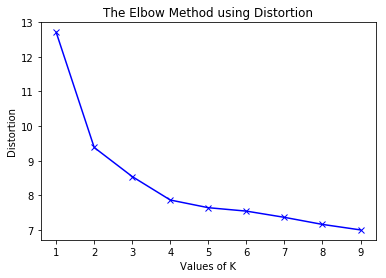

In [34]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

1 : 15606.117647058827
2 : 8191.566441441442
3 : 6617.914285714286
4 : 5710.1181210094255
5 : 5317.4363028276075
6 : 5171.192111592111
7 : 4985.36791958042
8 : 4729.129441391941
9 : 4521.767198161316


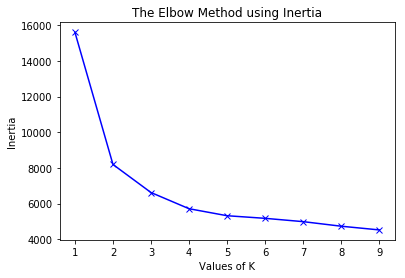

In [41]:
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val))
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

### The best number of cluster is 4

In [44]:
from sklearn.cluster import KMeans
import numpy as np


kclusters = 4

venue_clustering = venues_group_compare.drop(columns='Neighborhood')

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_clustering)

# check cluster labels generated for each row in the dataframe
venue_clustering['cluster']=pd.DataFrame(kmeans.labels_) 
venue_clustering['Neighborhood']=venues_group_compare['Neighborhood']


In [45]:

#cluster vs neighboordhoods
clusters=pd.DataFrame([])
clusters['cluster']=venue_clustering['cluster']
clusters['Neighborhood']=venues_group_compare['Neighborhood']



In [46]:
#For each cluster lets check the total number of restaurants
venues_group_sorted2=venues_group_sorted.merge(clusters,right_on='Neighborhood',left_on='Neighborhood',how='left')
cluster_total_restaurants=venues_group_sorted2.groupby(['cluster'])['Count'].sum()
cluster_total_restaurants=pd.DataFrame(cluster_total_restaurants)
cluster_total_restaurants.columns=['Total restaurants']
cluster_total_restaurants.reset_index(inplace=True)

In [47]:
cluster_total_restaurants

,cluster,Total restaurants
0,0,511
1,1,335
2,2,83
3,3,470


In [48]:
#Lets check the number of neighborhoods for each cluster
cluster_total_restaurants2=venues_group_sorted2.groupby(['cluster'])['Neighborhood'].count()
cluster_total_restaurants2

cluster
0    23
1    26
2    17
3    14
Name: Neighborhood, dtype: int64

### The dataset clustered enable, at least, the 2 method metioned earlier:

### a)Train and test the restaurant projection for each cluster
### b)Train and test the restaurant projection for all cluster together

# Linear regression

In [49]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

venue_regression=venue_clustering.drop(columns='Neighborhood')



C:\Users\cs315279\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### Method a) Score test for each cluster alone

In [73]:
total_mape=0
for i in range(0,4):
    venue_regression_cluster_a=venue_regression.loc[venue_regression['cluster']==i]
    venue_regression_cluster_a=venue_regression_cluster_a.drop(columns='cluster')
    x_a=venue_regression_cluster_a.drop(columns='Restaurant')
    y_a=venue_regression_cluster_a['Restaurant']
    X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(x_a, y_a, test_size=0.33, random_state=42)

    model = LinearRegression()
    model.fit(X_train_a, y_train_a)

    y_pred_a=pd.DataFrame(model.predict(X_test_a))

    from sklearn.metrics import mean_absolute_error
    mape_a=mean_absolute_error(y_test_a, y_pred_a)
    print('Average mean error for cluster '+str(i))
    print(mape_a)
    total_mape=mape_a+total_mape

    
Avarege_mape=total_mape/4
print('Average Mean Error for all cluster')
print(Avarege_mape)

Average mean error for cluster 0
2.469685977889607
Average mean error for cluster 1
1.9405418434426838
Average mean error for cluster 2
2.5635600839634365
Average mean error for cluster 3
4.2897034308394435
Average Mean Error for all cluster
2.815872834033793


### Method b) Score test for all cluster trained included

In [60]:
venue_regression_cluster_total=venue_regression.copy()
venue_regression_cluster_total=venue_regression_cluster_total.drop(columns='cluster')
x_total=venue_regression_cluster_total.drop(columns='Restaurant')
y_total=venue_regression_cluster_total['Restaurant']
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(x_total, y_total, test_size=0.33, random_state=42)

model = LinearRegression()
model.fit(X_train_total, y_train_total)

y_pred_total=pd.DataFrame(model.predict(X_test_total))


mape_total=mean_absolute_error(y_test_total, y_pred_total)

print(mape_total)

5.269325149270792


#### The Mean Error traing with all clusters togheter is 5.22%

## The winner method is the Method A, the separaly train models for each cluster. This method achieved a result of 2.81% mean error against 5.26% from the second method

## Number of restaurants projection for each neighborhood

In [99]:


#loop para cluster
#loop para cada index do cluster
result_hist=pd.DataFrame([])
result=pd.DataFrame([])
for i in range(0,4):
    venue_regression_cluster_0=venue_regression.loc[venue_regression['cluster']==i]
    venue_regression_cluster_0=venue_regression_cluster_0.drop(columns='cluster')
    index=pd.DataFrame(venue_regression_cluster_0.index)
    x_train=venue_regression_cluster_0.drop(columns='Restaurant')
    for x in range(0,len(index)):
        row=index.loc[x,0]
        x_0=x_train.copy()
        x_real=x_0.loc[[row]]
        x_0=x_0.drop([row])
        y_0=venue_regression_cluster_0['Restaurant']
        y_real=y_0.loc[[row]]
        y_0=y_0.drop([row])

        model = LinearRegression()
        model.fit(x_0, y_0)

        Lack_Restaurants=model.predict(x_real)-y_real.map(float)
        Lack_Restaurants=pd.DataFrame(Lack_Restaurants)
        Lack_Restaurants=Lack_Restaurants.reset_index(drop=False)
        result['Predicted Number of Restaurants']=model.predict(x_real)
        result['Actual of Number Restaurants']=pd.DataFrame(y_real.map(float)).reset_index().Restaurant
        result['Lack_Restaurants']=Lack_Restaurants['Restaurant']
        result['index_hist']=row
        result_hist=result_hist.append(result)
        result_hist

#The index neighborhood with the highest lack of restaurants:        
result_hist.sort_values(by=['Lack_Restaurants'], ascending=False)


,Predicted Number of Restaurants,Actual of Number Restaurants,Lack_Restaurants,index_hist
0,14.483317,3.0,11.483317,0
0,24.306804,17.0,7.306804,47
0,37.252818,30.0,7.252818,22
0,23.175517,18.0,5.175517,17
0,8.894292,4.0,4.894292,8
0,34.626458,30.0,4.626458,63
0,24.390057,20.0,4.390057,53
0,13.053998,9.0,4.053998,18
0,35.483911,32.0,3.483911,56
0,13.033215,10.0,3.033215,15


# Discussion

### The neighborhood the highest lack of restaurant by correlation is ALTO DE PINHEIROS

In [100]:
result_hist.set_index(['index_hist'])
print(venue_clustering.loc[[0]].Neighborhood)

0    Alto de Pinheiros‎, São Paulo
Name: Neighborhood, dtype: object


### Data treament to plot the heatmap

In [154]:
lack_of_restaurants=venue_clustering['Neighborhood'].copy()
lack_of_restaurants=result_hist['Lack_Restaurants']
venue_clustering_2=venue_clustering.reset_index(drop=False)
venue_clustering_2=venue_clustering_2.merge(result_hist, left_on='index', right_on='index_hist', how='left')
venue_clustering_2=venue_clustering_2.merge(addresses,left_on='Neighborhood',right_on='FullAddress',how='left')
lack_of_restaurants_result=pd.DataFrame([])
lack_of_restaurants_result['Neighborhood']=venue_clustering_2['FullAddress']
lack_of_restaurants_result['Actual of Number Restaurants']=venue_clustering_2['Actual of Number Restaurants']
lack_of_restaurants_result['Predicted Number of Restaurants']=venue_clustering_2['Predicted Number of Restaurants']
lack_of_restaurants_result['Lack of Restaurants']=venue_clustering_2['Lack_Restaurants']
lack_of_restaurants_result['Latitude']=venue_clustering_2['lat']
lack_of_restaurants_result['Longitute']=venue_clustering_2['long']

lack_of_restaurants_result.sort_values(by='Lack of Restaurants', ascending=False).head(10)

,Neighborhood,Actual of Number Restaurants,Predicted Number of Restaurants,Lack of Restaurants,Latitude,Longitute
0,"Alto de Pinheiros‎, São Paulo",3.0,14.483317,11.483317,-23.5533,-46.7096
48,"Moema‎, São Paulo",17.0,24.306804,7.306804,-23.602,-46.6721
23,"Consolação‎, São Paulo",30.0,37.252818,7.252818,-23.5521,-46.6526
17,"Casa Verde‎, São Paulo",18.0,23.175517,5.175517,-23.511,-46.6574
8,"Brasilândia‎, São Paulo",4.0,8.894292,4.894292,-23.4703,-46.69
64,"Saúde‎, São Paulo",30.0,34.626458,4.626458,-23.6183,-46.6355
54,"Perdizes‎, São Paulo",20.0,24.390057,4.390057,-23.5369,-46.6743
18,"Cidade Ademar‎, São Paulo",9.0,13.053998,4.053998,-23.6709,-46.6567
57,"República‎, São Paulo",32.0,35.483911,3.483911,-23.5451,-46.6428
15,"Capão Redondo‎, São Paulo",10.0,13.033215,3.033215,-23.6685,-46.769


In [193]:
heatmapdf=pd.DataFrame([])
heatmapdf['Latitude']=venue_clustering_2['lat']
heatmapdf['Longitute']=venue_clustering_2['long']
heatmapdf['Lack of Restaurants']=venue_clustering_2['Lack_Restaurants']
#heatmapdf=heatmapdf.reset_index().values.tolist()
#heatmapdf
max_amount = float(heatmapdf['Lack of Restaurants'].max())
hmap = folium.Map(location=[-23.5636, -46.6916], zoom_start=11, )
hm_wide = HeatMap( list(zip(heatmapdf['Latitude'].values, heatmapdf['Longitute'].values, heatmapdf['Lack of Restaurants'].values)),
                   min_opacity=0.2,
                   max_val=10,                   
                   radius=50, blur=30, 
                   max_zoom=1, 
                 )

hmap.add_child(hm_wide)

folium.Marker([-23.5533,-46.7096], popup='Alto de Pinheiros').add_to(hmap)
hmap

# Conclusion


### The recomendation is that the best place to start or maintain a restaurant is Alto de Pinheiros. This neigborhood has others businesses correlated to restaurants that indicates by linear regression a lack of 11.4 restaurants. 